,RAKE,YAKE,KBRT,RULF
all_docs,79.00,79.00,79.00,79.00
self_top1,0.00,0.00,0.00,0.00
soft,0.29,0.67,0.61,0.56
hard,0.01,0.05,0.05,0.04
avg,0.11,0.29,0.22,0.21
no_relevant,0.00,0.00,0.00,0.00


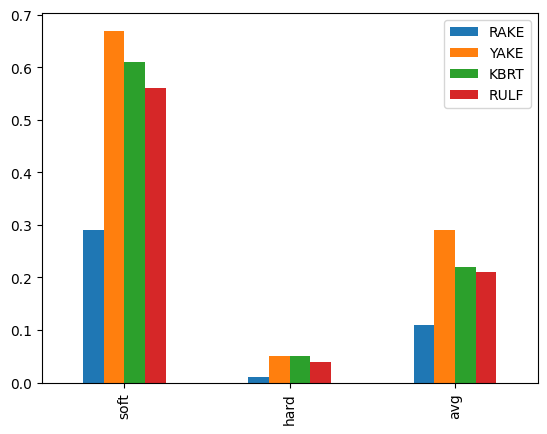

In [26]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


BASE_PATH = Path("data") / "eval"

with open(BASE_PATH / "eval.json") as file:
    rawdata = json.load(file)
data = {i: {} for i in rawdata.keys()}
for k, v in rawdata.items():
    for k1, v1 in v.items():
        if k1 not in ["all_docs", "self_top1", "no_relevant"]:
            data[k][k1] = v1

data = pd.DataFrame(data)
# plt.legend()
# plt.hist(data)

data.plot.bar()
# data
pd.DataFrame(rawdata)

In [2]:
# UPDATE 56 field
from documents import FileSystem
import json


async for doc in FileSystem("data\\raw\\skolkovo"):
    with open("data\\eval\\kwe\\" + doc.id + ".json", encoding="utf-8") as file:
        data = json.load(file)
    data["56"] = doc.citations
    with open("data\\eval\\kwe\\" + doc.id + ".json", "w", encoding="utf-8") as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

In [27]:
#
# Сравнить готовые терм вектора с полученными моей системой
#

from pathlib import Path
from lexis import lemmatize_ru_word
from documents import FileSystem
import pandas as pd
import json

BASE_PATH = Path("data") / "eval"

# old_docs = old system termvectors (keywords)

old_docs = {}

raw_data = pd.read_csv(BASE_PATH / "80_with_TV.csv", delimiter=";")

for idx, raw in raw_data.iterrows():
    id_mass = raw["Документ"].split("_")
    id = id_mass[-1] + id_mass[0] + id_mass[1]

    old_docs[id] = []
    for num in range(2, 52):
        word = raw[str(num)].split("~")[0]
        old_docs[id].append(lemmatize_ru_word(word))

# new_docs = my keywords

new_docs = {}

list_of_files = list((BASE_PATH / "kwe").iterdir())

for file_path in list_of_files:
    with open(file_path, encoding="utf-8") as file:
        data = json.load(file)
    new_docs[file_path.stem] = {
        extractor_name: list(map(lemmatize_ru_word, kws))
        for extractor_name, kws in data["keywords"].items()
    }

# evaluation dicts

eval_dict = {
    "all_docs": 0,
    "same_top1": 0,
    "soft": 0,
    "hard": 0,
    "avg": 0,
    "no_match": 0,
}

methods = ["RAKE", "YAKE", "KBRT", "RULF"]

metrics = {method: eval_dict.copy() for method in methods}

# evaluation

for new_doc_id, new_kws in new_docs.items():
    try:
        old_kw = old_docs[new_doc_id]
        for extractor_name, new_kw in new_kws.items():
            hits = 0
            for new_term in new_kw:
                if new_term in old_kw:
                    hits += 1

            metrics[extractor_name]["same_top1"] += new_kw[0] == old_kw[0]
            metrics[extractor_name]["soft"] += hits > 0
            metrics[extractor_name]["avg"] += hits / len(old_kw)
            metrics[extractor_name]["hard"] += hits == len(old_kw)
            metrics[extractor_name]["no_match"] += hits == 0
            metrics[extractor_name]["all_docs"] += 1

    except KeyError:
        continue

for extractor_name, eval in metrics.items():
    # print(extractor_name, "metrics:")
    for metric in eval.keys():
        if metric != "all_docs":
            eval[metric] = round(eval[metric] / eval["all_docs"], 2)

print("Метрики посчитаны")

Метрики посчитаны


            RAKE   YAKE   KBRT   RULF
all_docs   78.00  78.00  78.00  78.00
same_top1   0.01   0.37   0.08   0.08
soft        0.99   1.00   1.00   1.00
hard        0.00   0.00   0.00   0.00
avg         0.14   0.51   0.20   0.24
no_match    0.01   0.00   0.00   0.00


<AxesSubplot: >

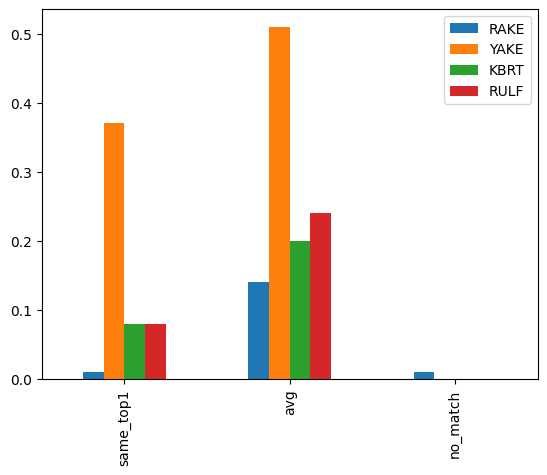

In [28]:
df = pd.DataFrame(metrics)
print(df)
df = df.drop(["soft", "all_docs", "hard"])
df.plot.bar()